In [9]:
# Importing Necessary Libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error 

# Importing Extra Libs
import sys, os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h1>Creating Extra Evaluating Metrics</h1>

In [10]:
def MRRE(matrix, predicted_matrix):
    sum_error = 0;
    eval_quantity = 0;
    
    for i in xrange(len(matrix)):
        for j in xrange(len(matrix[i])):
            if matrix[i][j] != 0:                
                sum_error += (matrix[i][j]-predicted_matrix[i][j])**2;
                eval_quantity += 1;
    
    return sqrt(sum_error/float(eval_quantity));

def RMSE(matrix, predicted_matrix):
    return sqrt(mean_squared_error(R, R_predicted))


<h1>Creating SAE Class for a Recommender System</h1>

In [5]:
class SAE:

    def __init__(self, input_matrix,
                 numNeurons = 16,                  
                 loss_metric = 'mse',
                 learning_rate = 0.001):
        
        # Always call base method before doing anything.
        self.input_matrix = input_matrix;
        self.num_neurons = numNeurons;                        
        self.loss_metric = loss_metric;
        self.learning_rate = learning_rate;  
        self.cv_metrics_values = {};
        
    def fit(self, verbose = False):
        
        # Splitting train and test set
        self.x_train, self.x_test = train_test_split(self.input_matrix);
        
        # Scaling input to range (-1,1)
        self.xNormScaler = MinMaxScaler(feature_range = (-1,1))
        self.xNormScaler.fit(x_train)

        self.x_norm_train = self.xNormScaler.transform(self.x_train)
        self.x_norm_test = self.xNormScaler.transform(self.x_test)

        #Setting autoencoder
        self.inputDim = self.x_norm_train.shape[1] #Number of items

        self.autoencoder = Sequential([
                                  Dense(num_neurons, activation = 'selu', kernel_initializer = 'uniform', input_dim = inputDim),
                                  Dense(inputDim, activation = 'tanh', kernel_initializer = 'uniform')
                                 ])

        #SGD = optimizers.SGD(lr=0.5, momentum=0.00, decay=0.0, nesterov=False)
        #Adam = optimizers.Adam(lr=0.0005, decay = 0.00001)
        self.Adam = optimizers.Adam(lr = self.learning_rate)

        self.autoencoder.compile(optimizer = self.Adam, loss = self.loss_metric, metrics=['mae'])
        #autoencoder.summary()
        
            self.earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto')

            time_zero = time.time()

            self.fitHistory = self.autoencoder.fit(
                                        self.x_norm_train, 
                                        self.x_norm_train, 
                                        epochs = 2000,
                                        verbose = 0,
                                        shuffle = True,
                                        validation_data = (self.x_norm_test, self.x_norm_test), 
                                        callbacks = [earlyStopping])

            self.predicted_matrix = self.predict(self.input_matrix);
        
        
        print('Time to fit model: '+str(time.time()-time_zero)+' seconds')
        
        return self    
        
    def cross_validate(self, n_folds = 10, metrics = ['rmse', 'mae', 'mrre'], verbose = True):
        for metric in metrics:
            self.cv_metrics_values[metric] = [];
        
        for i in xrange(n_folds):
            time_zero = time.time();
            self.fit(self.input_matrix);            
            fold_mae = self.evaluate('mae');
            fold_rmse = self.evaluate('rmse');
            fold_mrre = self.evaluate('mrre');
            self.cv_metrics_values['rmse'].append(fold_rmse)
            self.cv_metrics_values['mae'].append(fold_mae)
            self.cv_metrics_values['mrre'].append(fold_mrre)
            
            
            print ("Elapsed time for fold " + str(i) + ": ", time.time()-time_zero)
        
        return self.cv_metrics_values;
        
    def evaluate(self, metric = 'rmse'):
        
        if metric == 'rmse':
            return sqrt(mean_squared_error(self.input_matrix, self.predict(self.input_matrix)));
        elif metric == 'mae':
            return mean_absolute_error (self.input_matrix, self.predict(self.input_matrix));
        elif metric == 'mrre':
            return MRRE(self.input_matrix, self.predict(self.input_matrix))
        
        else:
            return "Invalid Metric: " + str(metric);
        
        
    def predict(self, matrix):
        # Creating scaler model
        matrix_norm_scaler = MinMaxScaler(feature_range = (-1,1));        
        
        # Fitting scaler model
        matrix_norm_scaler.fit(matrix);        
        
        # Creating normalized matrix
        matrix_norm = matrix_norm_scaler.transform(matrix);

        # Predicting output for normalized input matrix
        output = self.autoencoder.predict(matrix_norm);

        # Denormalizing output
        output_denormal = matrix_norm_scaler.inverse_transform(output);

        # Rounding denormalized output to nearest integer
        matrix_predicted = np.rint(output_denormal);
        
        return matrix_predicted

        #print R_predicted
        
    def estimate(self, u, i): # Estimates an evaluation from a given user to an item        
        return self.predicted_matrix[u][i]
    


<h1>Testing SAE Class</h1>

<h2> Loading the Dataset</h2>

In [8]:
# Choosing Dataset to be Used

dataset = '100k/' #100k dataset path
#dataset = '1M/' #1M dataset path
#dataset = '10M/' #10M dataset path
#dataset = '20M/' #20M dataset path

dataset_path = ('../../Datasets/movieLens/' + dataset) # Full dataset path

filenames = {'movie': 'movie.csv', 'rating': 'rating.csv'};

time_zero = time.time();

global df_ratings;
df_ratings = pd.read_csv(dataset_path+filenames['rating']);
print ("[Loading Time:",time.time()-time_zero,"s]",filenames['rating'],'Shape: ', df_ratings.shape)

FileNotFoundError: File b'../../Datasets/movieLens/100k/rating.csv' does not exist

<h2>Creating Utility Matrix</h2>

In [349]:
# Auxiliary Functions
global R;
global results_path;
results_path = './Results/';

global usersIds;
global moviesIds;

def InitializeIds():
    global usersIds;
    global moviesIds;


    usersIds = np.zeros(1);
    moviesIds = np.zeros(1);


    for count in xrange(len(df_ratings['rating'])):

        if df_ratings['userId'][count] in usersIds:
            pass;
        else:
            usersIds = np.append(usersIds, df_ratings['userId'][count]);   

        if df_ratings['movieId'][count] in moviesIds:
            pass;
        else:
            moviesIds = np.append(moviesIds, df_ratings['movieId'][count]);
            currentMovieId = df_ratings['movieId'][count];


def InitializeUtilityMatrix():
    InitializeIds();
    return np.zeros((usersIds.shape[0], moviesIds.shape[0]));

def FillUtilityMatrix():
    global R;
    for register in xrange(len(df_ratings['userId'])):
        userId = df_ratings['userId'][register];
        movieId = df_ratings['movieId'][register];

        #Getting userIndex from usersIds
        #itemindex = numpy.where(array==item) --> Return an array with indexes found
        userIndex = np.where(usersIds == userId);
        if len(userIndex[0]) == 0: # If userIndex hasn't found any matching user id in usersIds array
            print "UserId", userId, "not found in usersIds array.";
            pass;
        else:
            try:
                if len(userIndex[0]) > 1:
                    print "UserId ", userId, "is double-counted in usersIds.";
                userIndex = userIndex[0][0]; #Get the first occurance of userId match
            except IndexError:
                print "Error with user index: ", userIndex[0] ;
                pass;


        #Getting movieIndex from moviesIds
        #itemindex = numpy.where(array==item) --> Return an array with indexes found
        movieIndex = np.where(moviesIds == movieId);
        if len(movieIndex[0]) == 0: # If userIndex hasn't found any matching user id in usersIds array
            print "MovieId", movieId, "not found in usersIds array.";
            pass;
        else:
            try:
                if len(movieIndex[0]) > 1:
                    print "MovieId ", movieId, "is double-counted in moviesIds.";
                movieIndex = movieIndex[0][0]; #Get the first occurance of movieId match
            except IndexError:
                print "Error with movie index: ", movieIndex[0] ;
                pass;            

        R[userIndex][movieIndex] = df_ratings['rating'][register];
        
    return R;

def saveVariable(filename, variable):
    
    compression_parameter = 9;
    
    filepath = results_path+"Variables/"+dataset+filename;
    print "[*] Saving variable to " + filepath + " file...";
    if os.path.isfile(filepath): #Check if file already exists
        print "[*] Removing existing file...";
        os.remove(filepath);
        print "[+] Existing file removed.";    

    #joblib.dump(value, filename, compress=0, protocol=None, cache_size=None)
    joblib.dump(variable, filepath, compress = compression_parameter);
    print "[+] File saved.";   


In [350]:
time_zero = time.time();
global R;
R = InitializeUtilityMatrix();

print "Elapsed time: ", time.time()-time_zero;

R = FillUtilityMatrix();

print R.shape
print "Elapsed time: ", time.time()-time_zero;

Elapsed time:  5.91675901413
(944, 1683)
Elapsed time:  13.5611162186


[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.284822940826


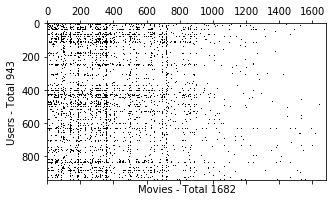

In [351]:
# Visualizing Matrix Sparsity
time_zero = time.time();

%matplotlib inline

#OS = calculateOverallSparsityMeasure(R);

fig, ax = plt.subplots(figsize = (5,5));

ax.spy(R);

plt.xlabel("Movies - Total "+str(R.shape[1]-1), fontsize = 10)
plt.ylabel("Users - Total "+str(R.shape[0]-1), fontsize = 10)
#plt.title("OS: " + str(OS) + '\n', fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=10)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'unsortedUtilityMatrix.png')

print "[+] Results saved."

print "Elapsed time: ", time.time()-time_zero; # Aprox. 5 s

<h2>Fitting SAE to Dataset</h2>

In [412]:
SAE_RS = SAE(R)
SAE_RS.fit();

Time to fit model: 17.2446098328 seconds


<h2>Visualizing Training History</h2>

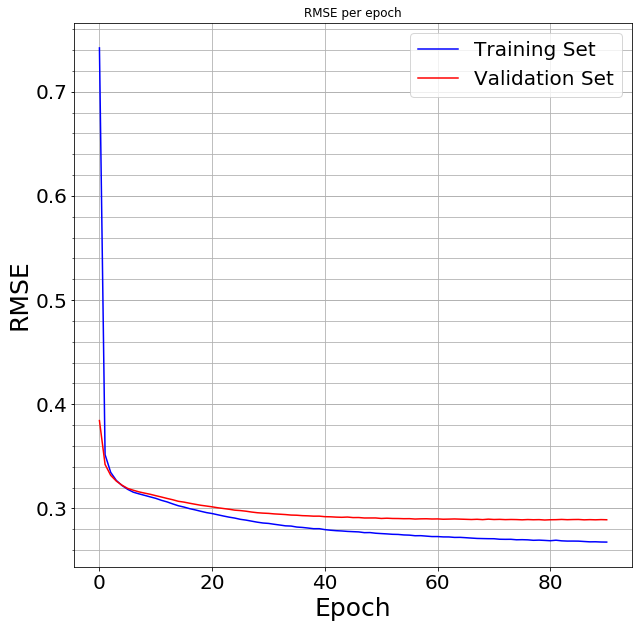

In [407]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
#print plt.subplots(figsize = (20,20), nrows = 2, ncols = 2)

tick_fontsize = 20
label_fontsize = 25
minor_ticks = [x/100.0 for x in xrange(20, 80,2)]

ax1.set_yticks(minor_ticks, minor = True)

ax1.grid(linestyle = '-', which = 'both')
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.set_title('RMSE per epoch')
ax1.set_xlabel('Epoch', fontsize = label_fontsize)
ax1.set_ylabel('RMSE', fontsize = label_fontsize)
trainingSet_1, = ax1.plot(np.sqrt(SAE_RS.fitHistory.history['loss']), 'b', label = 'Trainig Set')

validationSet_1, = ax1.plot(np.sqrt(SAE_RS.fitHistory.history['val_loss']), 'r', label = 'Validation Set')

ax1.legend(handles=[trainingSet_1, validationSet_1], labels=['Training Set', 'Validation Set'], prop={'size': tick_fontsize})


plt.savefig(results_path+'Figures/'+dataset+'SAE'+str(num_neurons)+'RMSE.png')

#fig.savefig('{}/{}.{}'.format(saveFigDir, 'RMSE_per_epoch_autoencoder_30_40', 'pdf'), bbox_inches='tight')

<h2>Evaluating Algorithm</h2>

In [373]:
print SAE_RS.fitHistory.history['val_mean_absolute_error'][-1]
print SAE_RS.fitHistory.history['val_loss'][-1]
#print MRRE(R, SAE_RS.predict(R))
#print RMSE(R, SAE_RS.predict(R))
#print SAE_RS.estimate(4,5)

0.102552862617
0.0827296039058


In [411]:
print SAE_RS.cv_metrics_values['mae']

[0.20341626635245777, 0.21022916100184297, 0.20232484365086562, 0.22040129611166503, 0.20396953080153477, 0.20755536421039911, 0.20833144505876311, 0.19362493328096522, 0.20058259564740119, 0.20913962657482099]


In [408]:
print SAE_RS.cross_validate()

Time to fit model: 14.8885519505 seconds
Elapsed time for fold 0:  16.5365390778
Time to fit model: 14.3471419811 seconds
Elapsed time for fold 1:  15.813491106
Time to fit model: 15.2793438435 seconds
Elapsed time for fold 2:  16.8315989971
Time to fit model: 14.6705951691 seconds
Elapsed time for fold 3:  16.5344719887
Time to fit model: 15.4385979176 seconds
Elapsed time for fold 4:  17.0769300461
Time to fit model: 16.3928558826 seconds
Elapsed time for fold 5:  18.0574941635
Time to fit model: 14.7476599216 seconds
Elapsed time for fold 6:  16.600933075
Time to fit model: 13.9695560932 seconds
Elapsed time for fold 7:  15.5276358128
Time to fit model: 16.1654090881 seconds
Elapsed time for fold 8:  18.1327719688
Time to fit model: 17.457365036 seconds
Elapsed time for fold 9:  19.1820321083


NameError: global name 'cv_metrics_values' is not defined

<h2> Reducing Dimensionality </h2>

In [198]:
U,s,V = np.linalg.svd(R, full_matrices = False);

print U.shape, s.shape, V.shape

(944, 944) (944,) (944, 1683)


In [199]:
S = np.zeros((s.shape[0], s.shape[0]))

S = np.diag(s)
print S.shape

(944, 944)


In [200]:

print np.allclose(R, np.dot(U, np.dot(S,V)))

True
